# Renfrewshire Food Hygiene Data Analysis

## Setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd

# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 9)

# Connect to the SQLite database
home_path = getcwd()
print(home_path)
conn = sqlite3.connect("/mnt/d/renfrewshire_business_insights/data/renfrewshire_hygiene.db") #adjust path accordingly

/mnt/d/renfrewshire_business_insights/reports


## Overview of Data

In [2]:
#Initial scoping of the SQL database to confirm all is working well
#List all entries
df = pd.read_sql_query("SELECT * FROM establishments;", conn)
df.head(10)

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,PostCode,...,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Longitude,Latitude,Geocode
0,1225663,79796,# Bar,Pub/bar/nightclub,7843,Units A And B,16 New Street,Paisley,Renfrewshire,PA1 1XY,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.426626,55.844654,None
1,136016,70018,102 Field Squadron,Restaurant/Cafe/Canteen,1,Main Buildings Ta Centre,65 Hawkhead Road,Paisley,Renfrewshire,PA1 3NE,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.398566,55.843739,None
2,459665,74595,1a Wok,Takeaway/sandwich shop,7844,None,28-30 Greenock Road,Bishopton,Renfrewshire,PA7 5JN,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.510428,55.909986,None
3,1559378,83646,21 Grains,Retailers - other,4613,None,30 Church Street,Lochwinnoch,Renfrewshire,PA12 4AD,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.6290181,55.7943695,None
4,1693818,83472,328 Asian Style Ltd,Takeaway/sandwich shop,7844,None,38 St James Street,Paisley,Renfrewshire,PA3 2JR,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.429109,55.848613,None
5,1622790,84048,A & A @ Gary Semples,Takeaway/sandwich shop,7844,Units 1 And 2 Quarrelton,Beith Road,Johnstone,Renfrewshire,PA5 8LF,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.5110934,55.8295789,None
6,1769927,85216,A & A Bakers,Restaurant/Cafe/Canteen,1,None,9 St James Street,Paisley,Renfrewshire,PA3 2HL,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.426984,55.848098,None
7,1343437,81485,A & A Paisley Ltd,Manufacturers/packers,7839,Unit 27 Mossedge Industrial Estate,Moss Road,Linwood,Paisley,PA3 3HR,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.489639,55.851034,None
8,134784,68275,A Bannatyne & Son,Retailers - other,4613,None,118 Paisley Road,Renfrew,Renfrewshire,PA4 8HE,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.397766,55.871464,None
9,1581537,83730,A Sweeter Side,Other catering premises,7841,None,None,None,None,None,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,None,None,None


## Hygiene Score Distribution

            RatingValue  Count
0                  Pass   1284
1                Exempt    115
2   Awaiting Inspection     34
3  Improvement Required     16
4     Pass and Eat Safe     12
Total counts is:  1461


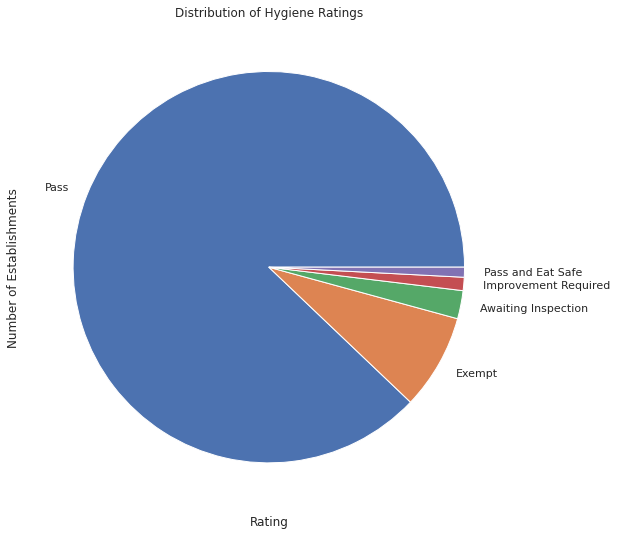

In [3]:
# Get rating value counts
rating_counts = pd.read_sql_query("""
SELECT RatingValue, COUNT(*) as Count
FROM establishments
GROUP BY RatingValue
ORDER BY Count DESC
""", conn)

# Plot
print(rating_counts) # print the data frame
total = rating_counts["Count"].sum()
print("Total counts is: ", total)

rating_counts.plot.pie(y = "Count", labels = rating_counts["RatingValue"], legend = False)
plt.title("Distribution of Hygiene Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Establishments")
plt.show()

## Business Types by Count

                             BusinessType  Count
0                       Retailers - other    298
1                 Restaurant/Cafe/Canteen    280
2                  Takeaway/sandwich shop    213
3                       Pub/bar/nightclub    144
4     Hospitals/Childcare/Caring Premises    136
5                 Other catering premises    131
6               School/college/university     83
7                          Mobile caterer     44
8   Retailers - supermarkets/hypermarkets     39
9                   Manufacturers/packers     38
10      Hotel/bed & breakfast/guest house     28
11              Distributors/Transporters     17
12                    Importers/Exporters      6
13                        Farmers/growers      4


/tmp/ipykernel_100/4120747233.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_counts, x="Count", y="BusinessType", palette="crest")


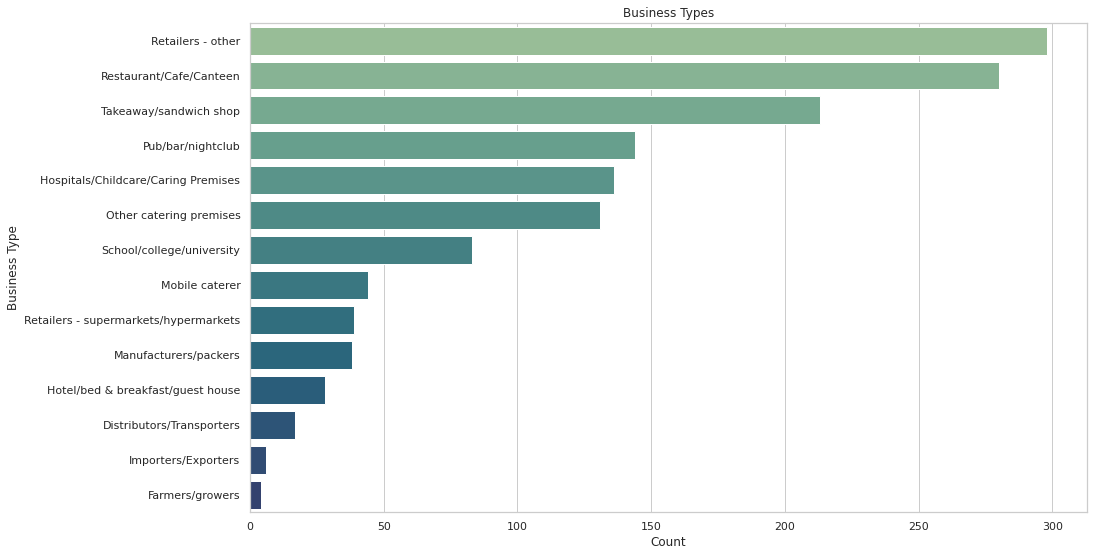

In [9]:
business_counts = pd.read_sql_query("""
SELECT BusinessType, COUNT(*) as Count
FROM establishments
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

print(business_counts)
sns.barplot(data=business_counts, x="Count", y="BusinessType", palette="crest")
plt.title("Business Types")
plt.xlabel("Count")
plt.ylabel("Business Type")
plt.show()

## Businesses by Post Code

Using the intial part of a UK postcode, an indication of geographical area can be found. Lets find how many business fit in these areas.

    Number of businesses PartPostCode
0                    337         PA1 
1                    235         PA3 
2                    181         PA4 
3                    170         PA5 
4                    136         PA2 
5                     79         None
6                     59         PA8 
7                     49         G51 
8                     41         PA7 
9                     35        PA11 
10                    35         G52 
11                    33        PA12 
12                    23         PA6 
13                    19        PA10 
14                    15         PA9 
15                     5        PA14 
16                     2        PA13 
17                     2        KY10 
18                     2             
19                     1         KY8 
20                     1         G69 
21                     1         G41 


/tmp/ipykernel_100/1788184663.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_by_area, x="Number of businesses", y="PartPostCode", palette="crest")


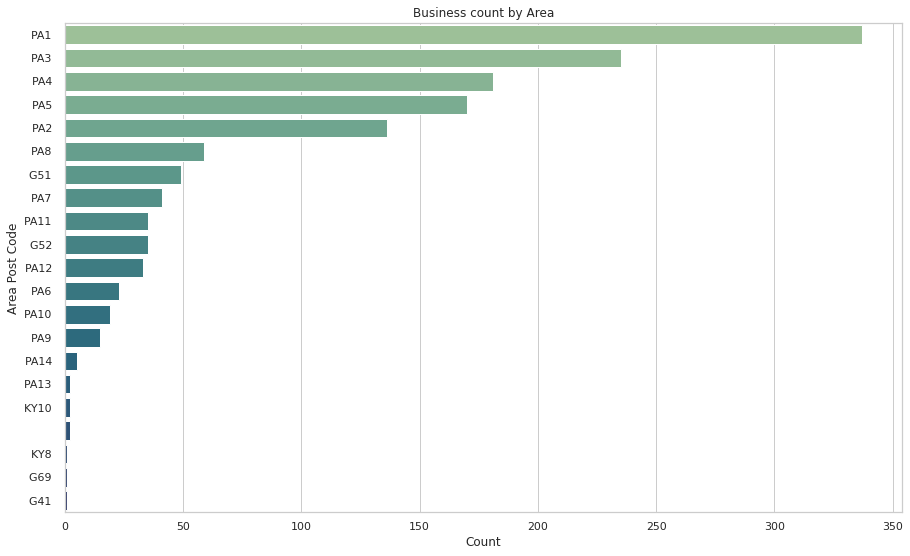

In [8]:
business_by_area = pd.read_sql_query("""
SELECT COUNT(*) as "Number of businesses", SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode
FROM establishments
GROUP BY PartPostCode
ORDER BY "Number of businesses" DESC;
""", conn)

print(business_by_area)
sns.barplot(data=business_by_area, x="Number of businesses", y="PartPostCode", palette="crest")
plt.title("Business count by Area")
plt.xlabel("Count")
plt.ylabel("Area Post Code")
plt.show()

### Outliers

There are three postcodes that start in KY, which is not a post code in the vicinity of Renfrewshire. We can look at these results more closely to determine why this could be.

In [22]:
#Will include a map using their lat and long data to show they are based in East Scotland
outliers = pd.read_sql_query("""
SELECT BusinessName, BusinessType, PostCode, AddressLine1,
AddressLine2, AddressLine3, AddressLine4
FROM establishments
WHERE PostCode LIKE "KY%";
""", conn)

outliers.head()

,BusinessName,BusinessType,PostCode,AddressLine1,AddressLine2,AddressLine3,AddressLine4
0,DM Fish Merchants Ltd,Mobile caterer,KY8 1HQ,None,55 Mavis Bank,Buckhaven,None
1,DNM Fish Mechant,Retailers - other,KY10 3YP,None,23 Lindsay Berwick Place,Anstruther,None
2,Sandra Hodge,Retailers - other,KY103HE,None,1 St Ayles Crescent,Anstruther,None
3,Yvonne Dehn,Mobile caterer,KY10 3YN,None,13 North Marches,Anstruther,Fife


## Save and Close

In [81]:
conn.close()